# Resevoir computing for the coupled Morse Hamiltonian

In this notebook we are going to solve the time-dependent Schrödinger equation

$$
i \hbar \frac{d \psi(x,y,t)}{dt} = \hat{H} \psi(x,y,t)
$$

for the 1D Harmonic Oscillator system. That is, the Hamiltonian $\hat{H}$ is:

$$
\hat{H}(x) = \frac{1}{2}G_{11}p_x^2 + \frac{1}{2}G_{11}p_y^2  +  G_{12}p_x p_y + U_{D_e,a,x_0}(x) + U_{D_e,a,x_0}(y)
$$

where

$$
U_{D_e,a,x_0}(x) = D_e (e^{-2a(x-x_0)} - 2e^{-a(x-x_0)})
$$

In this case we choose $G_{12} = \frac{\cos(\alpha)}{M_O}$, $G_{11} = \frac{M_H + M_O}{M_HM_O}$, $D_e = 0.20276 au$, $a=1.1484 au$, $x_0=0$, where $M_H$ and $M_O$ are the Hydrogen and Oxygen masses respectively and $\alpha$ is the bending angle. All units are atomic units so that $\hbar=1$. 

Starting from an initial wavefunction $\psi_0(x)$, we will propagate the wavepacket in time. In order to do so, we use a machine learning technique called Reservoir Computing.

In this notebook we use Reservoir Computing to obtain the **ground state** and **first excited states** of the previous Hamiltonian.

In [1]:
from integrateSchrodinger import*
#from complexRC import ComplexReservoirComputing, ComplexRidge
import numpy as np
import matplotlib.pyplot as plt

import scipy.linalg
from scipy.sparse import random
from scipy.sparse.linalg import eigs
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import mean_squared_error
from skimage.measure import block_reduce
from tqdm import tqdm

import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode()


## Generate training data

### Coupled Morse potenital

Let's define the initial wavepacket and Morse parameters.

In [2]:
# @hidden

##################################################################################################################
# Parameters

# specify dt and duration
dt = 0.015
t_max = 100000

# specify constants
hbar = 1.0   # planck's constant
m = 1.0      # particle mass

# Specify potential
MH = (1.00784/6.022e23)/9.109e-28
MO = (15.999/6.022e23)/9.109e-28
angle = 104.5
G11 = (MH+MO)/(MH*MO)
G12 = np.cos(angle*np.pi/180)/MO
print('MH={}, MO={}'.format(MH, MO))

De = 8.84e-12*22937126583.579#/4.4e-11
a = 2.175e8*0.528e-8
print('D={}, a={}'.format(De,a))
print('G11={}, G12={}'.format(G11,G12))

xe=0

# X Y axis
dx = 0.01
dy = 0.01
xmin=-0.9/a #1.2/a
xmax=1.5/a #2.2/a
ymin=-0.9/a #1.1/a
ymax=1.5/a #2.2/a
x = np.arange(xmin,xmax,dx)
y = np.arange(ymin,ymax,dy)

Nx = x.shape[0]
Ny = y.shape[0]


x_grid, y_grid = np.meshgrid(x, y, copy=False)
   
V = De*(1-np.exp(-a*(x_grid - xe)))**2 + De*(1-np.exp(-a*(y_grid - xe)))**2
                                            
# Initial state. Change the initial conditionto obtain higher energies
# First initial condition
x0,y0,p0x,p0y,deltax,deltay =0.2,-0.1,3,5,0.1,0.1
# Second initial condition
#x0,y0,p0x,p0y,deltax,deltay =0.5,0.5,10,10,0.1,0.1
# Third initial condition
#x0,y0,p0x,p0y,deltax,deltay =0.8,0.8,10,10,0.1,0.1
# Fourh initial condition
#x0,y0,p0x,p0y,deltax,deltay =0.9,0.9,15,15,0.1,0.1

psi0 = np.real(np.exp(-(x_grid- x0)**2/(4*deltax**2) - (y_grid - y0)**2/(4*deltay**2))*(\
       + np.exp(-1j*p0x*(x_grid-x0)/hbar -1j*p0y*(y_grid-y0)/hbar))) +0*1j


norm = calc_norm(psi0, xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax)
psi0 *=norm 

E = G11/2*p0x**2 + G11/2*p0y**2 + G12*p0x*p0y+ De*(1-np.exp(-a*(x0 - xe)))**2 + De*(1-np.exp(-a*(y0 - xe)))**2

print('Initial energy: ', E)

MH=1837.3002653315057, MO=29166.303128511227
D=0.20276419899883835, a=1.1484
G11=0.0005785629911337726, G12=-8.584564281295045e-06
Initial energy:  0.021248429829278218


### Plot the initial wavepacket

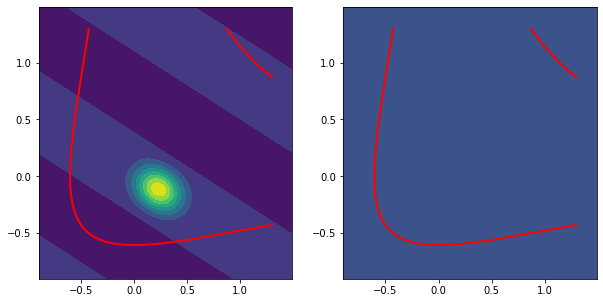

In [10]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
from skimage.measure import find_contours

contours = find_contours(V, De)

for contour in contours:
    contour = (xmax-xmin)/Nx*contour + xmin
    ax0.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)
    ax1.plot(contour[:, 1], contour[:, 0], color='red', linewidth=2)

ax0.contourf(x_grid*a, y_grid*a, psi0.real)
ax1.contourf(x_grid*a, y_grid*a, psi0.imag)

### Integrate the Schrödinger equation using the Kosloff method

The propagation of the wavepacket will be used as training and test data for the Reservoir computing algorithm. Be careful, this computation may take hours to run!

In [ ]:
################################################################################################################

# Generate data integrating the Schrodinger equation
name_file = 'coupled_morse_E01_'
S = IntegrateSchrodinger2D(x_grid, y_grid, psi0, V, dt=dt, G11=G11, G12=G12)
 
S.evolve(t_max, store_all=False, save_file=True, out_file=name_file, step=300)

S.join_files(name_file)

In [267]:
with open('coupled_morse_E01.npy', 'rb') as f:
            psi= np.load(f)
psi.shape

(22253, 105, 105)

### Let's visualize the wavepacket evolution

In [59]:
# @hidden

from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
plt.ioff()

# Steps to display the wavefunction. i.e we display psi(i*display)
interval=1

fig, ax=plt.subplots()
# Conservation of energy and momentum text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#textstr = '\n'.join((
#    r'$E=%.2f$' % (E[0], ),
#    r'$|\psi|^2=%.2f$' % (norm[0], )))


#timelabel = ax.text(0.08, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#        verticalalignment='top', bbox=props)

q1 = np.arange(xmin,xmax,dx*2)
q2 = np.arange(ymin,ymax,dy*2)
p = [ax.contourf(psi[0]) ]
fig.colorbar(p[0])

# Title
title = ax.set_title("")


def update(i):
    for tp in p[0].collections:
        tp.remove()
    
    psidata = psi[i*interval,:,:]
    p[0] = ax.contourf(psidata) 

    #timelabel.set_text('\n'.join((
    #                    r'$E=%.2f$' % (E[i*interval], ),
    #                    r'$|\psi|^2=%.2f$' % (norm[i*interval], ))))
    title.set_text("t = {:.2f}".format(dt*i*interval))
    
    return p[0].collections#+[timelabel]

ani = FuncAnimation(fig, update, frames=1000, interval=40, blit=True, repeat=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)

hide_toggle(title = "Animation")

C:\Users\laiad\anaconda3\lib\site-packages\numpy\ma\core.py:2825: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\laiad\anaconda3\lib\site-packages\numpy\ma\core.py:2825: ComplexWarning:

Casting complex values to real discards the imaginary part



## Dimensionality reduction

The complexity of Reservoir Computing mainly depends on the size of the internal weights $W \in \mathbb{R}^{N\times N}$, $W^\text{back} \in \mathbb{R}^{N\times L}$ . The larger $N$ and $L$ are, the longer it takes to train the network. The dimension $L$ is the size of the input, and $N$ should be of comparable size (or larger) than $N$ to ensure convergence of the method. Therefore, having high-dimensional inputs reduces the efficiency of the method. In this case, the size of the input depens on the number of grid points of the spatial domain. This in turn depends on the size of the desired wavefunctions and the level of detail needed to represent them. Therefore, the input size may be quite large in order to correctly describe the output. 

To avoid this dimensionality problem, we propose to represent the wavefunction $\psi(x,y,t)$ with the coefficients of its decomposition in a well-known basis of the Hilbert space. If the number of basis elements needed to correctly represent the wavefunction is not very large, we can achive a significant dimension reduction. In this case, we choose the decoupled Morse Hamiltonian basis, which have an analytical solution.

## Write the wavefunctions in the Morse basis

First, we try to compute the decomposition in the decoupled Morse eigenbasis. That is, given a wavefunction $\psi(x,y,t)$ and the Morse basis $\{\phi_n(x,y)\}_n$, we can write:

$$
\psi(x,y,t) =  \sum_n a_n(t) \phi_n(x,y)
$$

Notice that if the eigen eneregies of the studied system are similar to the energies of the Morse basis, we can approximate:

$$
\psi(x,y,t) = \sum_n \alpha_n(t) e^{-i E_n t/\hbar} \phi_n(x,y)
$$

Where $E_n$ are the energies of the Morse potential. We can calculate $\alpha_n(t)$ by

$$
a_n(t) = <\psi(t) | \phi_n> e^{i E_n t/\hbar} = e^{i E_n t/\hbar} \int_{x,y} \psi^*(x,y,t) \phi_n(x,y) dx dy
$$

Thus, we will represent our wavefunction $\psi(x,y,t)$ in the basis $\{\phi_n(x,y)\}_n$. The challenge will be for the reservoir computing model to predict the appropiate $\alpha_n(t)$, which encodes the time evolution of the wavepacket.

In [268]:
from scipy.special import eval_genlaguerre
# Morse true wavefunctions
# m = 1/G11
def Morse_wavefunction(n1=0, n2=0, hbar=1, m=1, De1=1, a1=1, 
                       xe1=0, De2=1, a2=1, xe2=0, x=0,y=0):
    x_grid, y_grid = np.meshgrid(x, y)
    # Psi(x)
    lamb = np.sqrt(2*m*De1)/(a1*hbar)
    w = (x_grid-xe1)*a1
    z = 2*lamb*np.exp(-w)
    exp = np.exp(-1/2*z) #exponential term
    pot = z**(lamb -n1 -1/2) # Potential term
    laguerre = eval_genlaguerre(n1, 2*lamb - 2*n1 -1, z)
    phi_x = pot*exp*laguerre
    E1 = - hbar*hbar*a1*a1/(2*m)*(lamb - n1-1/2)**2
    
    # Psi(y)
    lamb = np.sqrt(2*m*De2)/(a2*hbar)
    w = (y_grid-xe2)*a2
    z = 2*lamb*np.exp(-w)
    exp = np.exp(-1/2*z) #exponential term
    pot = z**(lamb -n2 -1/2) # Potential term
    laguerre = eval_genlaguerre(n2, 2*lamb - 2*n2 -1, z)
    phi_y = pot*exp*laguerre
    E2 = - hbar*hbar*a2*a2/(2*m)*(lamb - n2-1/2)**2
    
    phi_n = phi_x*phi_y
    h1 = (x[-1] - x[0])/x.shape[0]
    h2 = (y[-1] - y[0])/y.shape[0]
    C = 1/np.sqrt(np.sum(phi_n*phi_n*h1*h2))
    
    return phi_n*C, E1, E2

phis_morse = []
Es_morse=[]
x=np.arange(xmin,xmax,dx*2)
y = np.arange(xmin,xmax, dx*2)
for k1 in range(0,15):
    for k2 in range(0,15):
        w, E1, E2 = Morse_wavefunction(n1=k1, n2=k2, De2=De, a2=a, m = 1/G11,
                                       xe2=0, De1=De, a1=a, xe1=0, x=x, y=y)
        Es_morse.append(E1+E2+2*De)
        phis_morse.append(w)
        
Es_morse = np.sort(np.array(Es_morse))
phis_morse = np.array(phis_morse)[np.argsort(Es_morse)]    

hide_toggle(title = "Morse wavefunctions")

In [ ]:
from tqdm import tqdm

coefs_all2 = []
waves_hat2 = []
dt=0.015*300
x=np.arange(xmin,xmax,dx*2)
y = np.arange(xmin,xmax, dx*2)
size = x.shape[0]
h1 = x[1] - x[0]
h2 = y[1] - y[0]
for i in tqdm(range(psi.shape[0])):
    wave = psi[i]
    t = i*dt
    # find coeffs by integrating <psi(t)|phi_k>
    coefs = []
    for k in range(phis_morse.shape[0]):
        E = Es_morse[k]
        exp =np.exp(1j*E*t) 
        c = np.sum(phis_morse[k]*wave*h1*h2)*exp
        coefs.append(c)
    coefs = np.array(coefs)
    coefs_all2.append(coefs)
    E = Es_morse
    exp =np.exp(-1j*E*t).reshape(-1,1)
    wave_hat = np.dot(coefs,exp*phis_morse.reshape(-1,size*size)).reshape(size,size)
    waves_hat2.append(wave_hat)

coefs_all2 = np.array(coefs_all2)
waves_hat2 = np.array(waves_hat2)

### Visualize the evolution of the coefficients

In [337]:
# @hidden

from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
plt.ioff()

# Steps to display the wavefunction. i.e we display psi(i*display)
interval=1

fig, (ax1, ax2) =plt.subplots(1,2, figsize=(10,4))

max_coef = 100
# Plot data
x_data = np.arange(coefs_all2.shape[1])[:max_coef]
#Real
ln1 = ax1.scatter(x_data,  np.real(coefs_all2[0])[:max_coef],marker='x', c='b', s=3)
#Imaginary
ln2 = ax2.scatter(x_data, np.imag(coefs_all2[0])[:max_coef],marker='x', c='b', s=3)

# Title
title = ax1.set_title("")
title2 = ax2.set_title("")

def init():
    # Real
    ax1.set_ylim(-0.5, 0.5)
    # Imaginary
    ax2.set_ylim(-0.5, 0.5)
    
    return ln1,
    
def update(i):

    rdata = np.real(coefs_all2[i*interval])[:max_coef]
    rdata = np.c_[x_data,rdata]
    idata = np.imag(coefs_all2[i*interval])[:max_coef]
    idata = np.c_[x_data,idata]
    ln1.set_offsets(rdata)
    ln2.set_offsets(idata)
    title.set_text("t = {:.2f}".format(dt*i*interval))
    
    return ln1, ln2, title
ani = FuncAnimation(fig, update, frames=200,#int(coefs_all.shape[0]/interval),
                    interval=100,init_func=init,
                    blit=True, repeat=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)

hide_toggle(title = "Animation")

## Reservoir computing: Defining training parameters

Now we will apply the reservoir computing algorithm to propagate the coefficients in time. The firstt step is to define the training parameters, as well as the trianing ad test sets.

In [496]:
# @hidden

step = 1
coefs = coefs_all

### Parameters of the reservoir
t_step = 15000
n_min = 100
f = lambda x: np.tanh(np.real(x)) + 1j*np.tanh(np.imag(x))
f_out = lambda x: x#np.tanh
f_out_inverse = lambda x: x#np.arctanh

N = 500 # Number of nodes
L = coefs.shape[1]# Number of spatial steps (output dimension)
K = 0 # Input dimension
t_autonom = 7000
t_dismiss = 50

### Networks
# 1. Reservoir
def rand(n):
    np.random.seed(0)
    return np.random.choice([-0.5,0.5], n, p = [0.5,0.5])

W = scipy.sparse.random(N,N, density=0.025, random_state=1234, data_rvs = rand)
vaps,_ = eigs(W, k=15)
alpha = np.max(np.abs(vaps))
W = 0.04/alpha*W #Reescale the matrix to reduce the spectral radius

# 2. W^back
def rand2(n):
    np.random.seed(0)
    return np.random.uniform(low=-0.04, high=0.04, size=n)

W_back = scipy.sparse.random(N,L, density=1.0, random_state=1234, data_rvs = rand2)

# 3. W^in
def rand3(n):
    np.random.seed(0)
    return np.random.choice([-0.14,0.14], n, p = [0.5,0.5])

W_in = scipy.sparse.random(N,K, density=1.0, random_state=1234, data_rvs = rand3)

# Input
u = 0.1*np.ones((t_step,K))
u_test = 0.1*np.ones((t_autonom + t_dismiss,K))

# Initial states
initial_state = np.ones(N)

# Output
y_teach = coefs[:t_step,:]*1.5

# Output for prediction
y_true = coefs[t_step:(t_step + t_autonom),:]*1.5

hide_toggle(title = "Defining training parameters")

### Complex wavefunction


In [497]:
# Define the newtwork
net = ComplexReservoirComputing(n_min=n_min, t_step=t_step, W_in = W_in, W=W , W_back=W_back,
                         u = u, y_teach=y_teach, initial_state=initial_state, 
                         f=f, f_out=f_out, f_out_inverse = f_out_inverse)
#Train the network
train_mse=net.train(noise=True,boundary_noise=0.0001, ridge=True, augmented = False,
                    alpha = 5e-5, long_formula=True, C=0.9, a=1.0)

100%|██████████| 15000/15000 [06:39<00:00, 37.52it/s]


In [498]:
y_pred,test_mse = net.test(t_autonom, t_dismiss, u=u_test, y_true=y_true, 
                               augmented = False, long_formula=True,
                               C=0.9, a=1.0, update_x = False)

100%|██████████| 7050/7050 [00:55<00:00, 126.53it/s]


### Visualize the test mean squared error

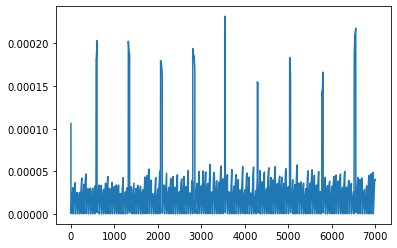

In [506]:
test_mse_time = np.real(np.mean(np.conjugate(y_true-y_pred[t_dismiss:])*(y_true-y_pred[t_dismiss:]), axis=1))
t = np.arange(0, y_pred.shape[0]*dt,dt)
plt.plot(test_mse_time/1.5**2)
plt.show()

In [501]:
print("Train mean MSE = {}".format(np.real(np.mean(train_mse))/1.5**2))
print("Test mean MSE = {}".format(np.real(np.mean(test_mse))/1.5**2))

Train mean MSE = 2.0742518527922674e-07
Test mean MSE = 2.7316797007403387e-05


### Visualize the quality of the predictions

In [505]:
from IPython.display import HTML, display
from matplotlib.animation import FuncAnimation
plt.ioff()

interval=10

fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(10,4))
x_data = np.arange(L)
#Real
ln2, = ax1.plot([], [], lw=2, color='blue')
ln1, = ax1.plot([], [], lw=2, color='red')
#Imag
ln4, = ax2.plot([], [], lw=2, color='blue')
ln3, = ax2.plot([], [], lw=2, color='red')
ax1.legend((ln1, ln2), ('True', 'Predicted'), loc='upper right')
ax2.legend((ln3, ln4), ('True', 'Predicted'), loc='upper right')

ax1.set_title('Real part')
ax2.set_title('Imaginary part')

fig.tight_layout(pad=3)

# Title
title = plt.suptitle('')

def init():
    # Real
    ax1.set_ylim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax1.set_xlim(-1,230)
    ax2.set_xlim(-1,230)
    return ln1,

def update(i):
    ln1.set_data(x_data,np.real(y_pred[t_dismiss + i*interval]))
    ln2.set_data(x_data,np.real(y_true[i*interval]))
    ln3.set_data(x_data,np.imag(y_pred[t_dismiss + i*interval]))
    ln4.set_data(x_data,np.imag(y_true[i*interval]))

    title.set_text("t = {:.2f}".format(dt*3*i))
    
    return ln1, ln2, ln3, ln4, title

ani = FuncAnimation(fig, update, frames=int(y_true.shape[0]/interval), interval=40,init_func=init, blit=True, repeat=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)

hide_toggle(title = "Animation")

## Revert to wavefunctions

Once we have the RC predictions of the coefficients in the Morse basis, we recover the wavefunctions.

In [ ]:
coefs_all_pred = np.concatenate((y_teach, y_pred[t_dismiss:]), axis=0)/1.5
coefs_all_pred.shape

In [26]:
from tqdm import tqdm

waves_hatb = []
dt=0.015*300
size = x.shape[0]
for i in tqdm(range(coefs_all_pred.shape[0])):
    t = i*dt
    E = Es_morse
    exp =np.exp(-1j*E*t).reshape(-1,1)
    wave_hat = np.dot(coefs_all_pred[i],exp*phis_morse.reshape(-1,size*size)).reshape(size,size)
    waves_hatb.append(wave_hat)

waves_hatb = np.array(waves_hatb)

100%|██████████| 22000/22000 [41:17<00:00,  8.88it/s]


In [29]:
psi_true = psi[:22000]
psi_pred = waves_hatb

## Obtaining the eigenfunctions

Once we have the time evolution of the wavefunctions we can calculate some of the eigenfunctions of the system. These wavefunctions have similiar eigen energies as the initial energy of the wavepacket. 

## Energy spectrum

We will calculate the energy spectrum of the true and predicted wavefunctions so as to find the eigen energies and eigen states.

The time-correlation function is defined as:

$$
A(t) = <\psi(t)|\psi(0)> = \int_y \int_x \psi(t)^* \psi(0) dx dy
$$

Then, the energy spectrum is the Fourier transform of the time-correlation function:

$$
I(E) = \int_t A(t) e^{-i E t/ \hbar} dt
$$

In [3]:
1000*19/33.9


560.47197640118

In [31]:
# @hidden

def time_correlation(psi_t, psi_0, xmin=-5, xmax=5, ymin=-5, ymax=5):
    N = psi_0.shape[0]
    h1 = (xmin-xmax)/N
    h2 = (ymin-ymax)/N
    A = np.sum(np.conjugate(psi_t)*psi_0*h1*h2)
    return A

def time_correlation_function(psi, xmin=-5, xmax=5,  ymin=-5, ymax=5):
    A = np.array([time_correlation(psi[i], psi[0], \
                 xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax) \
                  for i in range(psi.shape[0])])
    return A

def energy_spectrum(A, dt,t_max, E, hbar=1):
    t = np.arange(0, t_max, dt)
    I = np.sum(A*np.exp(-1j/hbar*E*t)*dt)
    return I

def energy_spectrum_function(A, dt, t_max, Emin=0, Emax=20, dE=0.05):
    E = np.arange(Emin, Emax, dE)
    I = np.array([energy_spectrum(A, dt,t_max, E[i])  
                  for i in tqdm(range(E.shape[0]))])
    return I

In [32]:
A_true = time_correlation_function(psi_true, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
A_pred = time_correlation_function(psi_pred, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

In [33]:
dt=0.015*300
t_max = psi_pred.shape[0]*dt
Emin=0.0
Emax=0.1
dE=0.000001
I_true = energy_spectrum_function(A_true, dt, t_max,
                                  Emin=Emin, Emax=Emax,dE=dE)
I_pred = energy_spectrum_function(A_pred, dt, t_max,
                                  Emin=Emin, Emax=Emax,dE=dE)

100%|██████████| 100001/100001 [02:21<00:00, 708.95it/s]


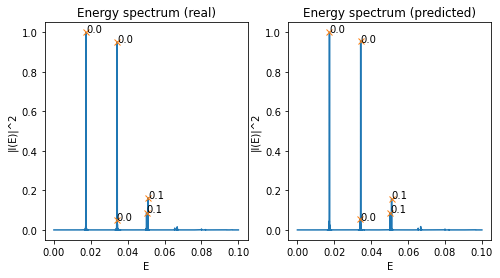

In [170]:
# @hidden

from scipy.signal import find_peaks

I_true_mod =  np.real(np.conjugate(I_true)*I_true)
I_true_mod /= np.max(I_true_mod)
peaks_true, _ = find_peaks(I_true_mod, height=0.051)

I_pred_mod =  np.real(np.conjugate(I_pred)*I_pred)
I_pred_mod /= np.max(I_pred_mod)
peaks_pred, _ = find_peaks(I_pred_mod, height=0.051)
E = np.arange(Emin, Emax, dE)

# PLOT
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.plot(E,I_true_mod)
ax1.plot(E[peaks_pred], I_true_mod[peaks_pred], "x")
ax1.set_title("Energy spectrum (real)")
ax1.set_xlabel("E")
ax1.set_ylabel("|I(E)|^2")

for i in range(peaks_pred.shape[0]):
    ax1.text(E[peaks_pred][i], I_true_mod[peaks_pred][i],
             round(E[peaks_pred][i],1), fontsize=10)

ax2.plot(E,I_pred_mod)
ax2.plot(E[peaks_pred], I_pred_mod[peaks_pred], "x")
ax2.set_title("Energy spectrum (predicted)")
ax2.set_xlabel("E")
ax2.set_ylabel("|I(E)|^2")
for i in range(peaks_pred.shape[0]):
    ax2.text(E[peaks_pred][i], I_true_mod[peaks_pred][i],
             round(E[peaks_pred][i],1), fontsize=10)
plt.show()

hide_toggle(title = "Energy spectrum")

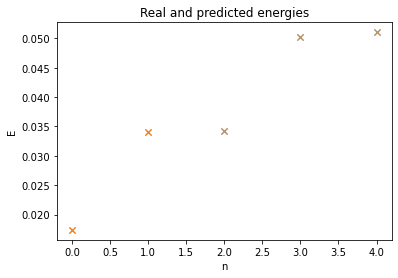

In [174]:
# @hidden
plt.plot( E[peaks_pred], 'x', label="Predicted")
plt.plot( E[peaks_true], 'x', label="Real")
plt.title('Real and predicted energies')
plt.xlabel('n')
plt.ylabel('E')
plt.show()
hide_toggle(title = "Real and predicted energies")

## Eigenstates

The eigenstates of the Hamiltonian are then:

$$
\phi_n(x,y) = \int_t \psi(x,y,t) e^{-i E_n t/\hbar} dt
$$

In [153]:
# @hidden
from scipy.special import eval_hermite

# Empirical wavefunctions
En = E[peaks_pred]
En_true = E[peaks_true]
t = np.arange(0, t_max, dt)

def eigenfunctions_emp(psi_pred, E,t,dt,x,y):
    phi_E= np.array([[np.sum(psi_pred[:,i,j]*np.exp(1j*E*t)*dt)
                      for i in range(psi_pred.shape[1])]
                      for j in range(psi_pred.shape[2])])
    
    h1 = (x[-1] - x[0])/x.shape[0]
    h2 = (y[-1] - y[0])/y.shape[0]
    C = 1/np.sqrt(np.sum(np.conjugate(phi_E)*phi_E*h1*h2))
    return phi_E*C

x = np.arange(xmin, xmax, dx*2)
y = np.arange(ymin, ymax, dy*2)
phi_n = np.array([eigenfunctions_emp(psi_pred, En[j],t,dt,x,y)
                  for j in tqdm(range(En.shape[0]))])
phi_n_true = np.array([eigenfunctions_emp(psi_true, En_true[j],t,dt,x,y)
                  for j in range(En_true.shape[0])])

  
hide_toggle(title = "Calculate the real and predicted wavefunctions")


100%|██████████| 5/5 [01:48<00:00, 21.74s/it]


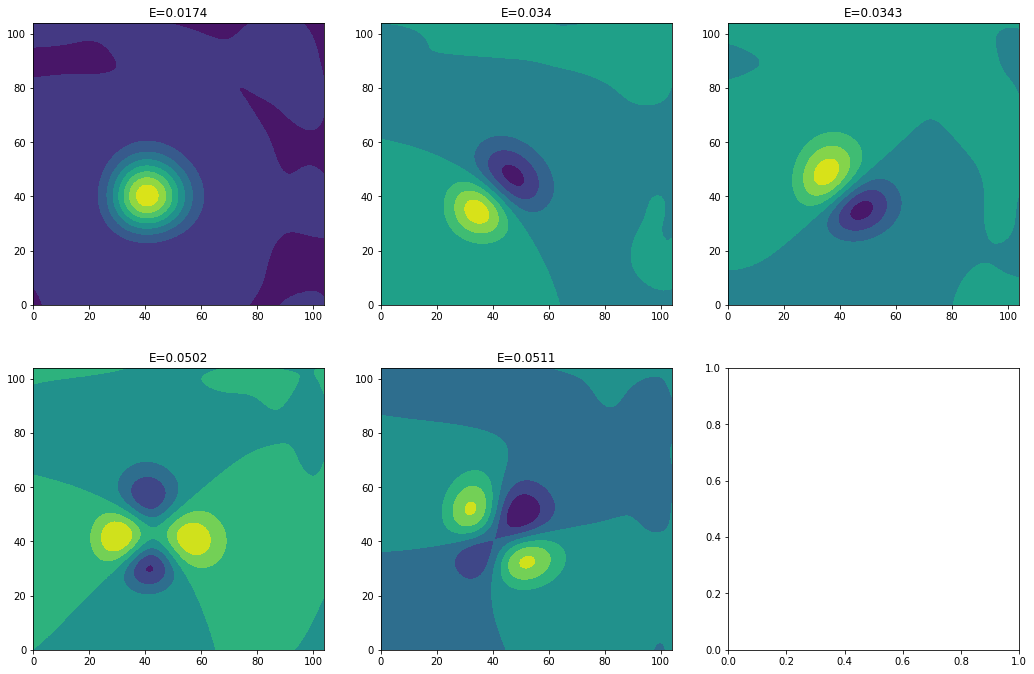

In [178]:
from scipy.ndimage.interpolation import rotate

lst = []

row = 2
col = 3

fig, ax = plt.subplots(row,col, figsize=(15,10))

h1 = (x[-1] - x[0])/x.shape[0]
h2 = (y[-1] - y[0])/y.shape[0]
for k in range(En.shape[0]):
    i = int(k/col)
    j = k%col
    if k in lst:
        C = 1/np.sqrt(np.sum(np.real(phi_n[k])*np.real(phi_n[k])*h1*h2))
        phi = C*np.real(phi_n[k])
        #phi = rotate(phi, angle=-45)
    else:
        C = 1/np.sqrt(np.sum(np.imag(phi_n[k])*np.imag(phi_n[k])*h1*h2))
        phi = C*np.imag(phi_n[k])
        #phi = rotate(phi, angle=-45)
    ax[i][j].contourf(phi)

    ax[i][j].set_title("E={}".format(round(En[k],4)))

plt.tight_layout(pad=3)
plt.show()
hide_toggle(title = "Predicted wavefunctions")

### Save the predicted eigenfunctions

In [165]:
with open('results/eigenfunctions/phis_true_morse01.npy', 'wb') as f:
            np.save(f, np.array(phi_n_true), allow_pickle=True)
        
with open('results/eigenfunctions/phis_pred_morse01.npy', 'wb') as f:
            np.save(f, np.array(phi_n), allow_pickle=True)